In [1]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import current
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path


class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = current.read(f, 'json')


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.worksheets[0].cells:
                if cell.cell_type == 'code' and cell.language == 'python':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.input)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod


class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

from load_dataset import *
from logistic_regression_model import *
from fairness_metrics import *

/anaconda3/lib/python3.7/site-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


importing Jupyter notebook from load_dataset.ipynb
importing Jupyter notebook from logistic_regression_model.ipynb
importing Jupyter notebook from fairness_metrics.ipynb


In [2]:
# Data Loading
filepath = "../data/Compas Dataset/processed_compas.csv"
label, protect = "is_recid", "race_African-American"

balanced = {"label_only":False,"downsample":True}
num_proxy_to_remove = 10
train_dataset, test_dataset = train_test_dataset(filepath, label, protect, 
                                                 is_scaled=True,
                                                 num_proxy_to_remove=num_proxy_to_remove,
                                                 balanced=balanced
                                                )

loaded
scaled
[('is_violent_recid', 0.19971898924985393), ('priors_count', 0.026471873215236166), ('juv_other_count', 0.019405451988199634), ('jail_stay_length', 0.017389173815172455), ('juv_misd_count', 0.017315741375295485), ('juv_fel_count', 0.011402849359983867), ('age_cat_Greater than 45', 0.01054737821976942), ('sex_Male', 0.008657313681444583), ('c_charge_desc_DUI Property Damage/Injury', 0.006195467794424293), ('age_cat_Less than 25', 0.005938614997110271)]  top_k
proxy removed
[[1071 1085]
 [1078 1078]]  balanced is_recid race_African-American
balanced


In [3]:
device = torch.device("cpu")

# Parameters
num_predictor_features = train_dataset[0][0].shape[0]
num_epochs = 40
lr_rate = 0.001
batch_size = 1000

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed(1))
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=np.random.seed(1))


# Model and Optimizer
torch.manual_seed(1)
predictor = Predictor(num_predictor_features).to(device)
optimizer = optim.Adam(predictor.parameters(), lr=lr_rate)

train_accuracies, test_accuracies = [], []
train_losses, test_losses = [], []
for epoch in range(1, num_epochs + 1):
    train_loss, train_accuracy = train(predictor, device, train_loader, optimizer, epoch)
    test_pred_labels, test_loss, test_accuracy = test(predictor, device, test_loader)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(train_loss)
    test_losses.append(test_loss)




Test set: Average loss: 1.28e+00, Accuracy: 573/1078 (53%)



/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")




Test set: Average loss: 1.28e+00, Accuracy: 572/1078 (53%)





Test set: Average loss: 1.28e+00, Accuracy: 568/1078 (53%)





Test set: Average loss: 1.28e+00, Accuracy: 579/1078 (54%)





Test set: Average loss: 1.28e+00, Accuracy: 590/1078 (55%)





Test set: Average loss: 1.28e+00, Accuracy: 593/1078 (55%)





Test set: Average loss: 1.28e+00, Accuracy: 593/1078 (55%)





Test set: Average loss: 1.28e+00, Accuracy: 597/1078 (55%)





Test set: Average loss: 1.28e+00, Accuracy: 599/1078 (56%)





Test set: Average loss: 1.28e+00, Accuracy: 602/1078 (56%)





Test set: Average loss: 1.28e+00, Accuracy: 599/1078 (56%)





Test set: Average loss: 1.28e+00, Accuracy: 602/1078 (56%)





Test set: Average loss: 1.28e+00, Accuracy: 602/1078 (56%)





Test set: Average loss: 1.28e+00, Accuracy: 600/1078 (56%)





Test set: Average loss: 1.28e+00, Accuracy: 597/1078 (55%)





Test set: Average loss: 1.28e+00, Accuracy: 597/1078 (55%)





Test set: Average loss: 1.28e+00, Accuracy: 597/1078 (55%)





Test set: Average loss: 1.28e+00, Accuracy: 602/1078 (56%)





Test set: Average loss: 1.28e+00, Accuracy: 601/1078 (56%)





Test set: Average loss: 1.28e+00, Accuracy: 601/1078 (56%)





Test set: Average loss: 1.28e+00, Accuracy: 602/1078 (56%)





Test set: Average loss: 1.28e+00, Accuracy: 603/1078 (56%)





Test set: Average loss: 1.27e+00, Accuracy: 603/1078 (56%)





Test set: Average loss: 1.27e+00, Accuracy: 604/1078 (56%)





Test set: Average loss: 1.27e+00, Accuracy: 599/1078 (56%)





Test set: Average loss: 1.27e+00, Accuracy: 603/1078 (56%)





Test set: Average loss: 1.27e+00, Accuracy: 603/1078 (56%)





Test set: Average loss: 1.27e+00, Accuracy: 602/1078 (56%)





Test set: Average loss: 1.27e+00, Accuracy: 602/1078 (56%)





Test set: Average loss: 1.27e+00, Accuracy: 608/1078 (56%)





Test set: Average loss: 1.27e+00, Accuracy: 608/1078 (56%)





Test set: Average loss: 1.27e+00, Accuracy: 608/1078 (56%)





Test set: Average loss: 1.27e+00, Accuracy: 608/1078 (56%)





Test set: Average loss: 1.27e+00, Accuracy: 608/1078 (56%)





Test set: Average loss: 1.27e+00, Accuracy: 608/1078 (56%)





Test set: Average loss: 1.27e+00, Accuracy: 608/1078 (56%)





Test set: Average loss: 1.27e+00, Accuracy: 608/1078 (56%)





Test set: Average loss: 1.27e+00, Accuracy: 608/1078 (56%)





Test set: Average loss: 1.27e+00, Accuracy: 606/1078 (56%)





Test set: Average loss: 1.27e+00, Accuracy: 606/1078 (56%)



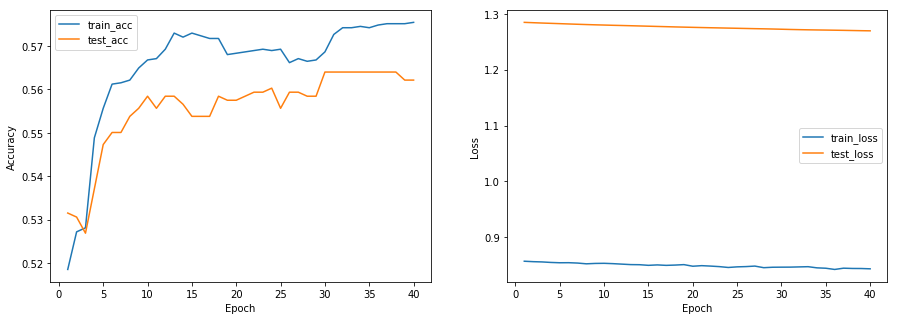

In [4]:
epochs = range(1, len(train_accuracies) + 1)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].plot(epochs, train_accuracies, label="train_acc")
ax[0].plot(epochs, test_accuracies, label="test_acc")
ax[1].plot(epochs, train_losses, label="train_loss")
ax[1].plot(epochs, test_losses, label="test_loss")

# plt.title("Logistic Regression: Simple")
ax[0].set_ylabel("Accuracy")
ax[1].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")
ax[1].set_xlabel("Epoch")
ax[0].legend()
ax[1].legend()
plt.show()

In [5]:
###### Fairness Metrics
print("Simple Logistic Model")

black_confusion_matrix = binary_confusion_matrix(test_loader.dataset.label, test_pred_labels, test_loader.dataset.protect, 1)
white_confusion_matrix = binary_confusion_matrix(test_loader.dataset.label, test_pred_labels, test_loader.dataset.protect, 0)

black_fpr = false_positive_rate(black_confusion_matrix)
white_fpr = false_positive_rate(white_confusion_matrix)


black_fnr = false_negative_rate(black_confusion_matrix)
white_fnr = false_negative_rate(white_confusion_matrix)

print(train_accuracy, "Train Acuuracy")
print(test_accuracy, "Test Acuuracy")

print(black_confusion_matrix, " Blacks")
print(white_confusion_matrix, " Whites")

print(frac_predicted_positive(black_confusion_matrix), frac_predicted_positive(white_confusion_matrix), "Fraction predicted positive females, males")
print(statistical_parity_difference(black_confusion_matrix, white_confusion_matrix), " statistical_parity_difference")

print(black_fpr - white_fpr, "FPR difference")
print(black_fnr - white_fnr, "FNR difference")

# print(female_fnr, male_fnr, " FNR Blacks, Whites")
# print(female_fpr, male_fpr, " FPR Blacks, Whites")
print(true_positive_rate_difference(black_confusion_matrix, white_confusion_matrix), " true_positive_rate_difference")
print(false_positive_rate_difference(black_confusion_matrix, white_confusion_matrix), " false_positive_rate_difference")
print(average_odds_difference(black_confusion_matrix, white_confusion_matrix), " average_odds_difference")


Simple Logistic Model
0.5754483611626469 Train Acuuracy
0.562152133580705 Test Acuuracy
[[126 142]
 [101 170]]  Blacks
[[151 119]
 [110 159]]  Whites
0.5788497217068646 0.5157699443413729 Fraction predicted positive females, males
0.06307977736549164  statistical_parity_difference
0.08911000552791593 FPR difference
-0.03622820614823247 FNR difference
0.03622820614823241  true_positive_rate_difference
0.08911000552791593  false_positive_rate_difference
0.06266910583807417  average_odds_difference


In [6]:
# (female_confusion_matrix[1,1] + male_confusion_matrix[1,1])/(np.sum(female_confusion_matrix[1,:]) + np.sum(male_confusion_matrix[1,:])) 
# (female_confusion_matrix[0,0] + male_confusion_matrix[0,0])/(np.sum(female_confusion_matrix[0,:]) + np.sum(male_confusion_matrix[0,:]))  



In [7]:
test_pred_labels_unique = test_pred_labels.unique()
test_pred_labels_unique_count = torch.stack([(test_pred_labels==x_u).sum() for x_u in test_pred_labels_unique])
test_pred_labels_unique_count, test_pred_labels_unique

(tensor([488, 590]), tensor([0, 1]))

In [8]:
compas_df = pd.read_csv(filepath)
conf = confusion_matrix(compas_df[label].values, compas_df[protect].values)
conf

array([[2621, 3113],
       [1078, 2135]])

In [9]:
conf[0,:]/np.sum(conf, axis=0), conf[1,:]/np.sum(conf, axis=0)

(array([0.70856988, 0.59317835]), array([0.29143012, 0.40682165]))